## Loading dependencies

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import json

## Declaring global constants

In [3]:
OBJ_ID             = "obj03"
OBJ_CONFIG         = json.load(open(f"../config/{OBJ_ID}.json"))
OBJ_VIDEO_PATH     = f"../data/{OBJ_ID}.mp4"
OBJ_MASK_PATH      = f"../processed/{OBJ_ID}/masks.npy"

CHROMA_LOWER_BOUND = [100, 60, 0]
CHROMA_UPPER_BOUND = [140, 255, 255]

## Performing the analysis

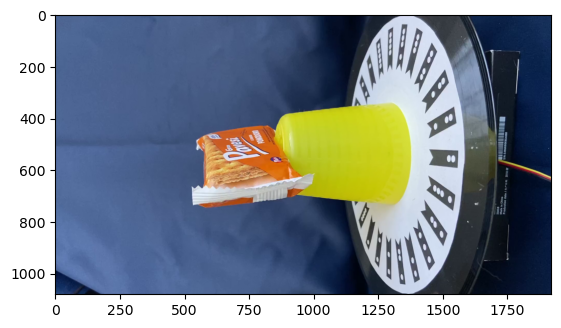

In [4]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)
    
assert cap.isOpened(), "Unable to acquire video stream"
    
ret, bgr_frame = cap.read()

cap.release()

rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)

plt.imshow(rgb_frame)

### 1. Chroma removal

The first thing to do in order to perform background-foreground segmentation through watershed is to roughly identify some foreground and background markers. We do chroma key removal using a color range mask. We then fill object holes, if necessary, and fill the disc markers. In this way, we have a thresholded image where sure foreground is white and possible background is black

In [30]:
def chroma_segment (fr):
    
    # 1. Roughly segment using chroma removal
    hsv  = cv.cvtColor(fr, cv.COLOR_BGR2HSV)
    masked = 255 - cv.inRange(hsv, np.array(CHROMA_LOWER_BOUND), np.array(CHROMA_UPPER_BOUND))
    
    # 2. Fill object holes if necessary
    retr_mode  = cv.RETR_EXTERNAL if OBJ_CONFIG["watershed"]["fill_holes"] else cv.RETR_CCOMP
    cnt_obj, _ = cv.findContours(masked[200:1000, 500:1000], retr_mode, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(masked, cnt_obj, -1, 255, -1, offset = (500, 200))
    
    # 3. Fill the markers
    cnt_mark,  _ = cv.findContours(masked[0:1080, 1100:1920], cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(masked, cnt_mark, -1, 255, -1, offset = (1100, 0))
    
    return masked

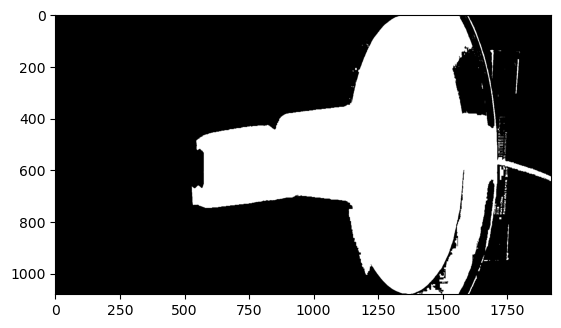

In [31]:
c_frame = bgr_frame.copy()
seg_frame = chroma_segment(c_frame)

plt.imshow(seg_frame, cmap = 'gray')

### 2. Distance thresholding

In order to better separate foreground from background, we perform distance-based thresholding:
1. Update each pixel such that its value represents the distance from the background
2. Normalize pixels values between 0 and 1
3. Perfom binary thresholding

In [23]:
def threshold_with_distance (seg):

    dist = cv.distanceTransform(seg, cv.DIST_L2, 3)
    
    cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    
    _, thresholded = cv.threshold(dist, 0.025, 1.0, cv.THRESH_BINARY)
    
    return dist, thresholded

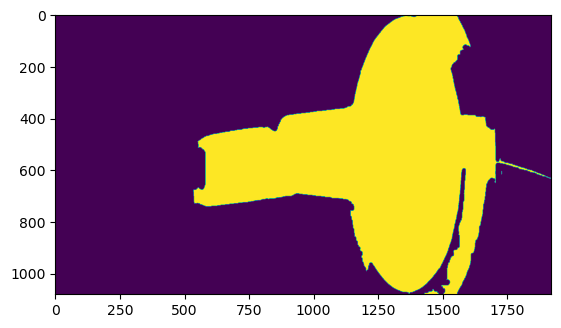

In [24]:
dist, th_frame = threshold_with_distance(seg_frame)
th_8_frame = th_frame.astype('uint8')

plt.imshow(th_8_frame)

### 3. Marker labeling

Now we are able to define the seeds for watersheding. We will update pixel values accordingly this convention:
- Foreground seed (hills): 1
- Background seed (valleys): -1
- Unsure f/b pixels: 0

We use _findContours_ with the RETR_CCOMP flag in order to detected holes in the foreground shapes. Holes' centers are then labeled as background seed, while the hole boundary shape is marked a foreground

In [25]:
# With cv.RETR_CCOMP retrieval mode we divide contours in two groups: external contours and hole contours

def get_markers (th_8_fr, dist):
    contours, h = cv.findContours(th_8_fr, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    
    markers = np.zeros(dist.shape, dtype=np.int32)
    cv.circle(markers, (20,20), 4, (255, 255, 255), -1)

    for i in range(len(contours)):
        is_hole = h[0][i][3] != -1
        if (is_hole):
            M = cv.moments(contours[i])
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv.circle(markers, (cx,cy), 4, (255, 255, 255), -1)
        else:
            cv.drawContours(markers, contours, i, 1, thickness = cv.FILLED, hierarchy = h, maxLevel = 1)
    
    return markers

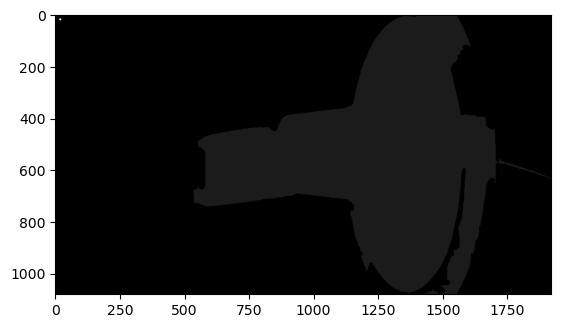

In [26]:
markers = get_markers(th_8_frame, dist)
plt.imshow((markers * 25).astype('uint8'), cmap = 'gray')

### 4. Watershed

We are now able to perform watershed. The water filling will start from the valleys and then stop in the presence of a hill. The algorithm implementation will choose if unsure pixels will be filled or not. We finally apply the resulted watersheded image with binary mask to the original frame, splitting the background from the foreground 

In [27]:
masks = []

cap = cv.VideoCapture(OBJ_VIDEO_PATH)

while (cap.isOpened()):
    ret, frame = cap.read()
    
    if not ret:
        break
    
    segmented = chroma_segment(frame)
    
    dist, thresholded = threshold_with_distance(segmented)
    
    thresholded_u8 = thresholded.astype('uint8')
    
    markers = get_markers(thresholded_u8, dist)
    
    cv.watershed(frame, markers)
    
    mask = cv.bitwise_not(markers.astype('uint8'))

    bin_mask = (mask / 254).astype('uint8')
    
    masks.append(bin_mask)
    
    fully_segmented = cv.bitwise_and(frame, frame, mask = mask)
    
    cv.imshow('frame', mask)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
     
cap.release()
cv.destroyAllWindows()

### 5. Save the results

In [11]:
np.save(OBJ_MASK_PATH, np.array(masks))